In [20]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import signal
import argparse

def calculate_allan_deviation(times, freqs, tau_max=None):
    """
    Calculate Allan deviation for a time series of frequencies.
    
    Args:
        times: Array of timestamps
        freqs: Array of frequencies
        tau_max: Maximum tau to calculate (in seconds). If None, uses half the total time.
    
    Returns:
        taus: Array of tau values
        allan_dev: Array of Allan deviations
    """
    from scipy.interpolate import interp1d
    
    # Check if data is on uniform grid
    dt = np.diff(times)
    if not np.allclose(dt, dt[0], rtol=1e-6):
        print("Warning: Non-uniform time steps detected, interpolating to uniform grid")
        
        # Create uniform time grid
        dt_uniform = np.median(dt)  # Use median as the uniform time step
        t_uniform = np.arange(0, times[-1]-times[0], dt_uniform)
        
        # Interpolate frequencies to uniform grid
        interp_func = interp1d(times, freqs, kind='linear', bounds_error=False, fill_value='extrapolate')
        freqs_uniform = interp_func(t_uniform)
        
        # Use interpolated data
        times = t_uniform
        freqs = freqs_uniform
        dt = np.diff(times)

        print(f"Uniform time step: {dt_uniform}")
    
    # Calculate fractional frequency deviations
    # For Allan deviation, we need fractional frequency y_i = (f_i - f_avg) / f_avg
    f_avg = np.mean(freqs)
    y = (freqs - f_avg) / f_avg
    
    print(f"Data length: {len(y)}")
    print(f"Time step: {dt[0]}")
    print(f"Total time: {times[-1] - times[0]}")
    print(f"Fractional frequency range: {np.min(y):.2e} to {np.max(y):.2e}")
    
    # Calculate Allan deviation
    if tau_max is None:
        tau_max = (times[-1] - times[0]) / 3  # Use 1/3 instead of 1/2 for better statistics
    
    # Use fewer points for better statistics at each tau
    n_taus = min(50, int(np.log10(tau_max/dt[0]) * 10))
    taus = np.logspace(np.log10(dt[0]), np.log10(tau_max), n_taus)
    allan_dev = np.zeros_like(taus)
    
    for i, tau in enumerate(taus):
        m = int(tau / dt[0])
        if m < 1:
            m = 1
        
        # Need at least 3 points for Allan variance calculation
        if len(y) < 3*m:
            allan_dev[i] = np.nan
            continue
            
        # Calculate Allan variance using the standard formula
        # AVAR(tau) = (1/2) * <(y_{i+1} - y_i)^2> where y_i is averaged over tau
        
        # Create averaged samples over tau
        n_avg = len(y) // m
        if n_avg < 3:
            allan_dev[i] = np.nan
            continue
            
        y_avg = np.zeros(n_avg)
        for j in range(n_avg):
            y_avg[j] = np.mean(y[j*m:(j+1)*m])
        
        # Calculate Allan variance
        if len(y_avg) < 2:
            allan_dev[i] = np.nan
            continue
            
        var = 0.5 * np.mean(np.diff(y_avg)**2)
        allan_dev[i] = np.sqrt(var)
        
        print(f"tau={tau:.3f}s, m={m}, n_avg={n_avg}, ADEV={allan_dev[i]:.2e}")
    
    # Remove NaN values
    valid_mask = ~np.isnan(allan_dev)
    taus = taus[valid_mask]
    allan_dev = allan_dev[valid_mask]
    
    return taus, allan_dev

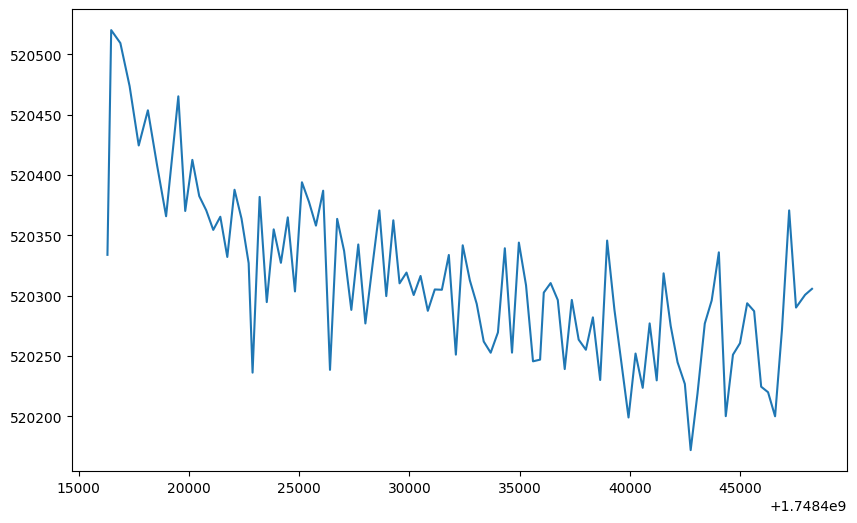

Uniform time step: 318.6106708049774
Data length: 101
Time step: 318.6106708049774
Total time: 31861.06708049774
Fractional frequency range: -9.11e-06 to 9.11e-06
tau=318.611s, m=1, n_avg=101, ADEV=1.29e-07
tau=409.296s, m=1, n_avg=101, ADEV=1.29e-07
tau=525.793s, m=1, n_avg=101, ADEV=1.29e-07
tau=675.447s, m=2, n_avg=50, ADEV=2.58e-07
tau=867.698s, m=2, n_avg=50, ADEV=2.58e-07
tau=1114.668s, m=3, n_avg=33, ADEV=3.87e-07
tau=1431.933s, m=4, n_avg=25, ADEV=5.16e-07
tau=1839.500s, m=5, n_avg=20, ADEV=6.44e-07
tau=2363.071s, m=7, n_avg=14, ADEV=9.02e-07
tau=3035.665s, m=9, n_avg=11, ADEV=1.16e-06
tau=3899.697s, m=12, n_avg=8, ADEV=1.55e-06
tau=5009.656s, m=15, n_avg=6, ADEV=1.93e-06
tau=6435.539s, m=20, n_avg=5, ADEV=2.58e-06
tau=8267.268s, m=25, n_avg=4, ADEV=3.22e-06
tau=10620.356s, m=33, n_avg=3, ADEV=4.25e-06


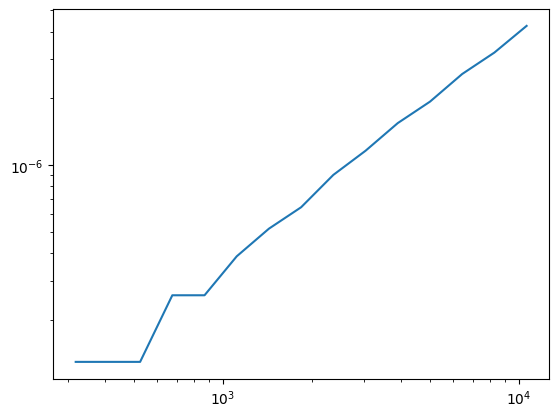

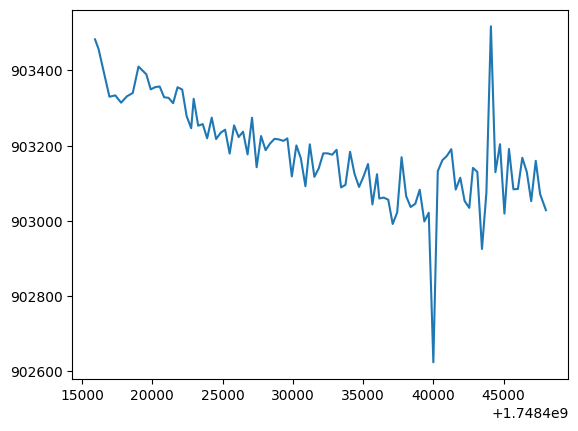

Uniform time step: 319.6292688846588
Data length: 101
Time step: 319.6292688846588
Total time: 31962.92688846588
Fractional frequency range: -9.09e-06 to 9.09e-06
tau=319.629s, m=1, n_avg=101, ADEV=1.29e-07
tau=410.604s, m=1, n_avg=101, ADEV=1.29e-07
tau=527.474s, m=1, n_avg=101, ADEV=1.29e-07
tau=677.607s, m=2, n_avg=50, ADEV=2.57e-07
tau=870.472s, m=2, n_avg=50, ADEV=2.57e-07
tau=1118.232s, m=3, n_avg=33, ADEV=3.86e-07
tau=1436.511s, m=4, n_avg=25, ADEV=5.14e-07
tau=1845.380s, m=5, n_avg=20, ADEV=6.43e-07
tau=2370.626s, m=7, n_avg=14, ADEV=9.00e-07
tau=3045.370s, m=9, n_avg=11, ADEV=1.16e-06
tau=3912.164s, m=12, n_avg=8, ADEV=1.54e-06
tau=5025.672s, m=15, n_avg=6, ADEV=1.93e-06
tau=6456.114s, m=20, n_avg=5, ADEV=2.57e-06
tau=8293.698s, m=25, n_avg=4, ADEV=3.22e-06
tau=10654.309s, m=33, n_avg=3, ADEV=4.24e-06


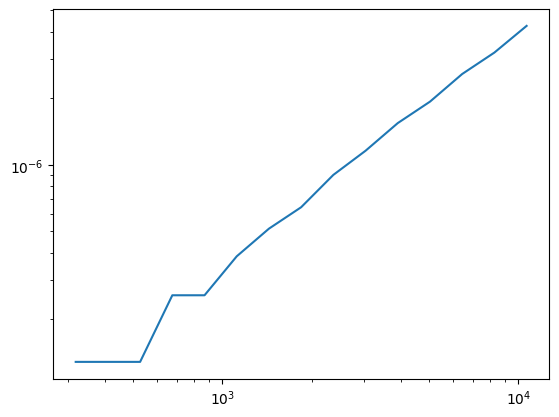

/tmp/ipykernel_2894486/1927578535.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


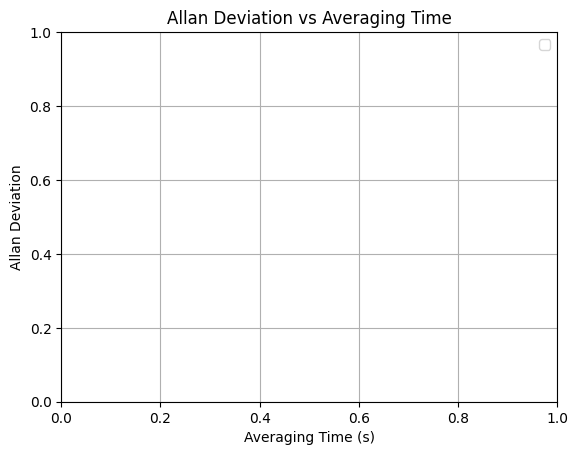

[1.28614841e-07 1.28614841e-07 1.28614841e-07 2.57229683e-07
 2.57229683e-07 3.85844524e-07 5.14459366e-07 6.43074207e-07
 9.00303890e-07 1.15753357e-06 1.54337810e-06 1.92922262e-06
 2.57229683e-06 3.21537103e-06 4.24428977e-06]


In [21]:
"""
Load data and plot Allan deviation for each mode.

Args:
    data_file: Path to the JSON data file
    modes: List of modes to analyze. If None, analyzes all available modes.
"""

data_file = "./drift_tracker_motion_20250527_222814.json"
# Load data
with open(data_file, 'r') as f:
    data = json.load(f)

plt.figure(figsize=(10, 6))

# If no modes specified, use all available modes

modes = ['mode1', 'mode2']#, 'mode2', 'single_ion']

# Process each specified mode
for mode in modes:
    if mode in data:
        times = np.array(data[mode]['times'])
        freqs = np.array(data[mode]['freqs'])

        plt.plot(times, freqs)
        plt.show()
        
        # Calculate Allan deviation
        taus, allan_dev = calculate_allan_deviation(times, freqs)
        
        # Plot
        plt.loglog(taus, allan_dev, label=mode)
        plt.show()
    else:
        print(f"Warning: Mode '{mode}' not found in data file")

plt.xlabel('Averaging Time (s)')
plt.ylabel('Allan Deviation')
plt.title('Allan Deviation vs Averaging Time')
plt.grid(True)
plt.legend()
plt.show()
print(allan_dev)